# A Simple DCGAN

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import array_to_img
import time
import cv2
from google.colab.patches import cv2_imshow


from IPython import display

In [ ]:
#(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# or
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5


BUFFER_SIZE = 10000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


170500096/170498071 [==============================] - 3s 0us/step


In [ ]:

# Generator

generator = tf.keras.models.Sequential()

generator.add(layers.Dense(8*8*256, use_bias=False, input_shape=(128,)))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Reshape((8, 8, 256)))
assert generator.output_shape == (None, 8, 8, 256)

generator.add(layers.Conv2DTranspose(filters=256, kernel_size=(5, 5), padding='same', use_bias=False))
assert generator.output_shape == (None, 8, 8, 256)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), padding='same', use_bias=False))
assert generator.output_shape == (None, 8, 8, 128)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), padding='same', use_bias=False))
assert generator.output_shape == (None, 8, 8, 128)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator.output_shape == (None, 16, 16, 64)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
assert generator.output_shape == (None, 32, 32, 3)

In [ ]:
# Discriminator

discriminator = tf.keras.models.Sequential()

discriminator.add(layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Flatten())

discriminator.add(layers.Dense(1))

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:

def discriminator_loss(real, fake):
    real_loss = loss(tf.ones_like(real), real)
    fake_loss = loss(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

In [ ]:
def generator_loss(fake):
    return loss(tf.ones_like(fake), fake)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, decay=1e-8)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, decay=1e-8)

In [ ]:
checkpoints_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoints_dir, 'ckpt')

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, 
                                 discriminator_optimizer=discriminator_optimizer, 
                                 generator=generator, 
                                 discriminator=discriminator)

In [ ]:
epochs = 400
noise_dim = 128
num_examples_to_generate = 16

In [ ]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)
        
        real = discriminator(images, training=True)
        fake = discriminator(generated, training=True)
        
        gen_loss = generator_loss(fake)
        disc_loss = discriminator_loss(real, fake)
        
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        image = array_to_img(predictions[i] * 127.5 + 127.5, scale=False)
        plt.subplot(4, 4, i+1)
        plt.imshow(image)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Note: To see a good result, we need a good GPU and a lot of hours.

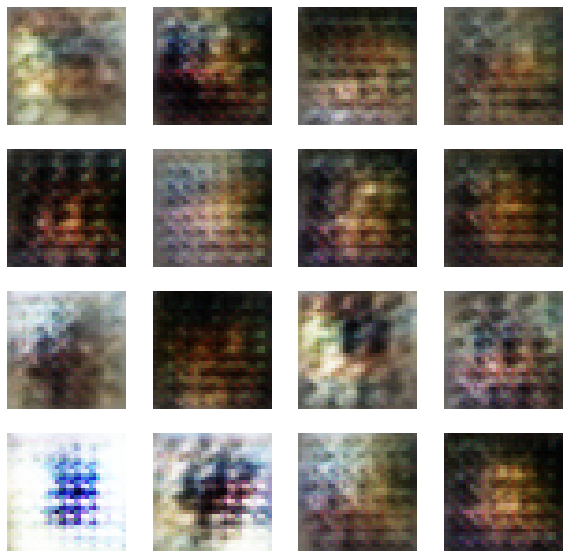

KeyboardInterrupt: ignored

In [ ]:
for epoch in range(epochs):
    for batch in train_dataset:
        train_step(batch)
    
    if epoch % 20 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

In [ ]:
checkpoint.save(file_prefix=checkpoint_prefix)
display.clear_output(wait=True)
generate_and_save_images(generator, epoch + 1, seed)